In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from patsy import dmatrix
from pygam import LinearGAM

%matplotlib inline

### 6

In [2]:
# Load dataset
wage = pd.read_csv('../../data/Wage.csv')
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
# Subset dataset
X = wage['age'].values.reshape(-1,1)
y = wage['wage']

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=100)

In [4]:
# POLYNOMIAL REGRESSION

# initialize empty dict
scores = {}

# Cross val with polynomial with degree 1 through 5
for d in range(1,6):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)
    lm = LinearRegression()
    lm_model = lm.fit(X_train_poly,y_train)
    lm_preds = lm_model.predict(X_valid_poly)
    score = mean_squared_error(y_valid,lm_preds)
    scores[d] = score
    
minval = min(scores.values())
mindegree = [k for k,v in scores.items() if v == minval]
    
print(scores)
print(f'Optimal polynomial degree: {mindegree}')

{1: 1729.4307871910755, 2: 1658.044351376369, 3: 1653.3265224812828, 4: 1658.2859333414, 5: 1658.6258357953827}
Optimal polynomial degree: [3]


/Users/hassansaad/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 333.25527471319606)

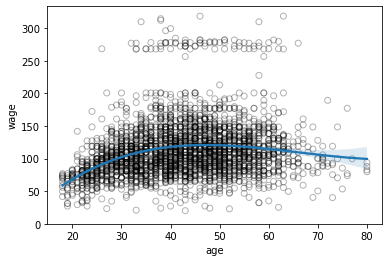

In [5]:
# Scatter plot with polynomial regression line for degree 3
fig, ax = plt.subplots(1,1)
ax.scatter(wage['age'], wage['wage'], facecolor = 'None', edgecolor = 'k', alpha=0.3)
sns.regplot(wage['age'], wage['wage'], order = mindegree[0], truncate=True, scatter=False, ax=ax)
ax.set_ylim(ymin=0)

In [6]:
# STEP FUNCTION
X_train_df = pd.DataFrame(X_train, columns = ['age'])
X_valid_df = pd.DataFrame(X_valid, columns = ['age'])

# initialize empty dictionary
scores = {}

for cut in range(1,7):
    
    # Generate cuts
    X_train_cut, bins = pd.cut(X_train_df['age'], cut, retbins = True, right = True)
    X_train_steps = pd.concat([X_train_df, X_train_cut], keys = ['age','age_cuts'], axis = 1)

    # Create dummy variables for the age groups
    X_train_steps_dummies = pd.get_dummies(X_train_steps['age_cuts'])
    
    # Put the test data in the same bins as the training data.
    X_valid_cut = pd.cut(X_valid_df['age'], bins)
    
    X_valid_steps = pd.concat([X_valid_df, X_valid_cut], keys = ['age','age_cuts'], axis = 1)

    # Create dummy variables for the age groups
    X_valid_steps_dummies = pd.get_dummies(X_valid_steps['age_cuts'])
    
    lm = LinearRegression()
    lm_model = lm.fit(X_train_steps_dummies,y_train)
    lm_preds = lm_model.predict(X_valid_steps_dummies)
    score = mean_squared_error(y_valid, lm_preds)
    scores[cut] = score

minval = min(scores.values())
mincut = [k for k,v in scores.items() if v == minval]
print(scores)
print(f'Optimal number of bins: {mincut}')

{1: 1782.3636113596724, 2: 1777.1292708349322, 3: 1712.3017446610527, 4: 1676.7229722281068, 5: 1700.407279563322, 6: 1690.466667906789}
Optimal number of bins: [4]


### 7

In [7]:
# Load dataset
wage = pd.read_csv('../../data/Wage.csv')
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [8]:
# Create X and y objects
X = wage['maritl'].values.reshape(-1,1)
y = wage['wage']

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=100)

In [9]:
# Convert categorical data into dummies 
X_train_df = pd.DataFrame(X_train, columns = ['Married'])
X_train_dummies = pd.get_dummies(X_train_df)

X_valid_df = pd.DataFrame(X_valid, columns = ['Married'])
X_valid_dummies = pd.get_dummies(X_valid_df)

In [10]:
# Fit linear regression model
lm = LinearRegression()
lm_model = lm.fit(X_train_dummies,y_train)
lm_preds = lm_model.predict(X_valid_dummies)
score = mean_squared_error(y_valid,lm_preds)
print(score)

1678.9925947590073


### 8

In [11]:
# Load dataset
auto = pd.read_csv('../../data/Auto.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [12]:
# Prepare X and y objects
X_full = auto.drop('mpg', axis=1)
y = auto['mpg']

numerical_cols = [col for col in X_full.columns if X_full[col].dtype in ['int64', 'float64']]
X = X_full[numerical_cols]

In [13]:
# Create train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=100)

# POLYNOMIAL REGRESSION

# initialize empty dict
scores = {}

# Cross val with polynomial with degree 1 through 5
for d in range(1,6):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)
    lm = LinearRegression()
    lm_model = lm.fit(X_train_poly,y_train)
    lm_preds = lm_model.predict(X_valid_poly)
    score = mean_squared_error(y_valid,lm_preds)
    scores[d] = score
    
minval = min(scores.values())
mindegree = [k for k,v in scores.items() if v == minval]
    
print(scores)
print(f'Optimal polynomial degree: {mindegree}')

{1: 11.29486009973578, 2: 30.38451809723879, 3: 41.00913196428355, 4: 122915.39350575005, 5: 214692.12870915173}
Optimal polynomial degree: [1]


### 9

In [14]:
# Load dataset
boston = pd.read_csv('../../data/Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Polynomials

In [15]:
# Create X and y objects
X = boston['dis'].values.reshape(-1,1)
y = boston['nox']

# Create train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=100)

# POLYNOMIAL REGRESSION

# initialize empty dict
scores = {}

# Cross val with polynomial with degree 1 through 5
for d in range(1,11):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)
    lm = LinearRegression()
    lm_model = lm.fit(X_train_poly,y_train)
    lm_preds = lm_model.predict(X_valid_poly)
    score = mean_squared_error(y_valid,lm_preds)
    scores[d] = score
    
minval = min(scores.values())
mindegree = [k for k,v in scores.items() if v == minval]
    
print(scores)
print(f'Optimal polynomial degree: {mindegree}')

{1: 0.005857559731691039, 2: 0.004105005613250629, 3: 0.0036841497692329654, 4: 0.003791476444587175, 5: 0.005248948507110164, 6: 0.009457442441787763, 7: 0.02175874934218148, 8: 0.006210471465195287, 9: 0.013699620511841997, 10: 0.011185001851195081}
Optimal polynomial degree: [3]


#### Splines

In [ ]:
transformed_x_train = dmatrix("bs(train, df=4, degree=3, include_intercept=False)",
                             {"train": X_train}, return_type ='dataframe')
transformed_x_valid = dmatrix("bs(valid, df=4, degree=3, include_intercept=False)",
                             {"valid": X_valid}, return_type ='dataframe')
# Fitting Generalised linear model on transformed dataset
glm_model = sm.GLM(y_train, transformed_x_train).fit()

In [16]:
# UNABLE TO FIGURE OUT HOW TO FIT REGRESSION SPLINES IN PYTHON

### 10

In [35]:
# Load dataset
college = pd.read_csv('../../data/College.csv')
college = college.iloc[:,1:]
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [36]:
# Create X and y, and split into test and training set
X = college.drop('Outstate', axis=1)
y = college['Outstate']

X = pd.get_dummies(X)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,random_state=100)

In [37]:
# Do model selection by fitting a Lasso regression using crosss-val to select lambda
alphas = [0.01,0.1,1.0,10.0]

lasso_reg = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_model_cv = lasso_reg.fit(X_train,y_train)
lasso_model = Lasso(alpha = lasso_model_cv.alpha_).fit(X_train,y_train)
lasso_preds = lasso_model.predict(X_valid)
lasso_score = mean_squared_error(y_valid, lasso_preds)
print(f'Mean Squared Error from Lasso Regression: {lasso_score}')

# Report number of non-zero coefficients
pd.Series(lasso_model.coef_, index = X_train.columns) # Can remove Private_Yes from the model it has a zero coefficient 

Mean Squared Error from Lasso Regression: 4156401.2939300193


Apps          -3.450718e-01
Accept         7.978941e-01
Enroll        -1.227618e-01
Top10perc      3.541849e+01
Top25perc      1.536290e+00
F.Undergrad   -1.711286e-01
P.Undergrad    5.087273e-02
Room.Board     8.945062e-01
Books         -2.437810e-01
Personal      -2.799213e-01
PhD            1.332377e+01
Terminal       2.279427e+01
S.F.Ratio     -2.453136e+01
perc.alumni    5.081295e+01
Expend         1.816728e-01
Grad.Rate      1.694519e+01
Private_No    -2.032488e+03
Private_Yes    1.602020e-11
dtype: float64

In [38]:
# Drop 'Private_Yes' and recreate a train_test set
X = X.drop('Private_Yes', axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,random_state=100)

In [55]:
# Fit GAM on the training set with grid search to determine best values for n_splines and lambda
gam = LinearGAM().gridsearch(X_train.values,y_train.values)
real_gam = gam.fit(X_train,y_train)
preds_gam = real_gam.predict(X_valid)
score = mean_squared_error(y_valid, preds_gam)
print(score)

100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


3805304.0665798225


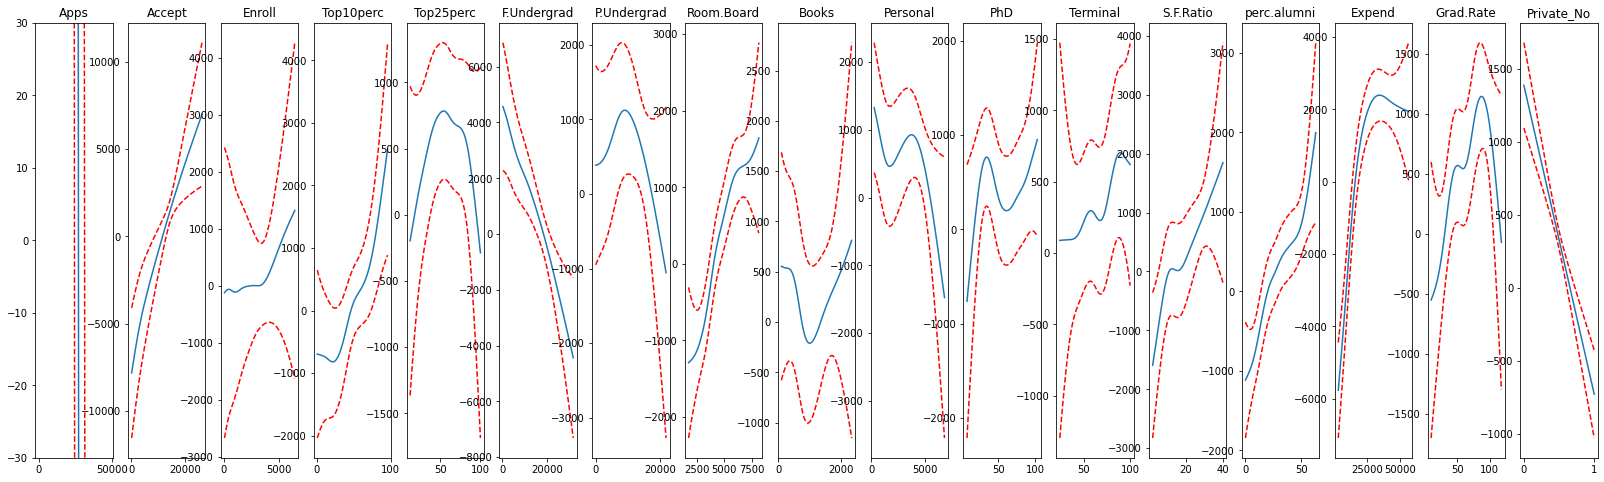

In [57]:
# Plot relationships
fig, axs = plt.subplots(1, len(X.columns))
titles = X.columns

for i, ax in enumerate(axs):
    XX = real_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], real_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], real_gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

### 11

In [58]:
# Generate data
x1 = np.random.normal(loc=0, scale=1,size=100)
x2 = np.random.normal(loc=0, scale=0.5, size=100)
y = (0.5*x1) + (3*x2) + -1

In [67]:
# Initialize Beta1
beta1 = 0
lm = LinearRegression()

# Step c
a = y-(beta1*x1)
model = lm.fit(x2.reshape(-1,1),a)
beta2 = model.coef_[0]

# Step d
a = y-(beta2*x2)
model = lm.fit(x1.reshape(-1,1),a)
beta1 = model.coef_[0]

beta0 = model.intercept_

print(beta0,beta1,beta2)

-1.000504289167551 0.49981423368862304 3.0170586029142976


In [69]:
# For loop repeating above steps 1-7
beta0s = []
beta1s = []
beta2s = []

beta1 = 0

for i in range(1,1001):
    # Step c
    a = y-(beta1*x1)
    model = lm.fit(x2.reshape(-1,1),a)
    beta2 = model.coef_[0]
    beta2s.append(beta2)

    # Step d
    a = y-(beta2*x2)
    model = lm.fit(x1.reshape(-1,1),a)
    beta1 = model.coef_[0]
    beta1s.append(beta1)

    beta0 = model.intercept_
    beta0s.append(beta0)
    

[0.49981423368862304,
 0.49999993098175505,
 0.4999999999743574,
 0.4999999999999904,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.49999999

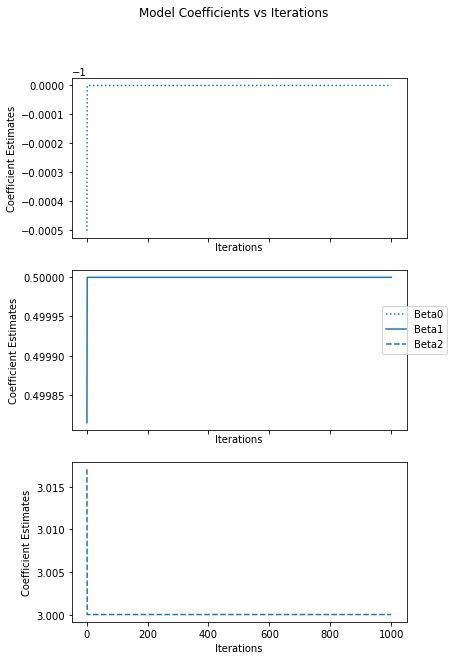

In [119]:
iterations = [i for i in range(1,1001)]

fig, axes = plt.subplots(3,1,figsize=(6,10),sharex=True)
axes[0].plot(iterations,beta0s, label = 'Beta0', linestyle='dotted')
axes[1].plot(iterations,beta1s, label = 'Beta1', linestyle='solid')
axes[2].plot(iterations,beta2s, label = 'Beta2', linestyle='--')
fig.legend(loc='right')
fig.suptitle('Model Coefficients vs Iterations')
for ax in axes:
    ax.set(xlabel='Iterations', ylabel='Coefficient Estimates')

In [124]:
X = pd.DataFrame({'x1': x1, 'x2': x2})
lm = LinearRegression()
model = lm.fit(X,y)
model.coef_

array([0.5, 3. ])